A Data Analysis on Titanic Shipwreck Passenger Data

By Stephen Fox
May 2016

(completed as part of the Udacity Introduction to Programming Nanodegree)

Introduction:

I have chosen to complete an analysis on the Titanic shipwreck passenger data. The data provides a variety of demographic data on 891 of the passengers, many of whom did not survive the disaster.  

The particular question I would like to explore is whether certain factors, namely age, gender and socioeconomic class, were predictive of whether someone survived the disaster or did not. I will use the cabin class purchased (1,2, or 3) as an indicator of upper, middle and lower classes, respectively. This is the approach endorsed by the compilers of the data (https://www.kaggle.com/c/titanic/data).

In [48]:
import pandas as pd
import numpy as np

In [49]:
# Import the raw data

titanic_data = pd.read_csv('titanic_data.csv')

I would like to begin by making sure the dataset is clean. I will achieve this by doing sanity checks on various fields:

In [50]:
# Check that the number of unique names matches the expected count (891, per the project specifications)

print "passenger count: "  + str(len(titanic_data['Name'].unique()))

# Confirm that there are only three cabin classes

print "cabin class count: " + str(len(titanic_data['Pclass'].unique()))

# Confirm that there are only two genders in the data

print "gender count: " + str(len(titanic_data['Sex'].unique()))

# Sanity check that the age data looks reasonable (no unreasonably large or small ages, for example)

print "oldest passenger: " + str(titanic_data['Age'].max())
print "youngest passenger: " + str(titanic_data['Age'].min())

passenger count: 891
cabin class count: 3
gender count: 2
oldest passenger: 80.0
youngest passenger: 0.42


There are now obvious issues with the data. The passenger count, gender options and cabin class number all match expectations. The age range looks reasonable, ranging from a few months to 80 years.

I would now like to get a sense of how my data splits along the variables of interest, namely gender, class age and whether or not a passenger survived. I will do this by getting basic statistical data for each variable.

In [51]:
print "Gender statistics:"
print titanic_data['Sex'].describe()
print "\n"

print "Cabin statistics:"
print titanic_data['Pclass'].describe()
print "\n"

print "Age statistics:"
print titanic_data['Age'].describe()
print "\n"

print "Survival statistics:"
print titanic_data['Survived'].describe()

Gender statistics:
count      891
unique       2
top       male
freq       577
Name: Sex, dtype: object


Cabin statistics:
count    891.000000
mean       2.308642
std        0.836071
min        1.000000
25%        2.000000
50%        3.000000
75%        3.000000
max        3.000000
Name: Pclass, dtype: float64


Age statistics:
count    714.000000
mean      29.699118
std       14.526497
min        0.420000
25%       20.125000
50%       28.000000
75%       38.000000
max       80.000000
Name: Age, dtype: float64


Survival statistics:
count    891.000000
mean       0.383838
std        0.486592
min        0.000000
25%        0.000000
50%        0.000000
75%        1.000000
max        1.000000
Name: Survived, dtype: float64


Looking at the gender data, I observe that a majority of the passengers were male (577 out of 891, or 64%). Thus, the gender data is not representative of normal society, where a 50:50 split between males and females is expected. 

I also observe that a majority of the passengers were lower class (3rd class passengers), given that the median for cabin statistics is '3'. 

I also notice that the age data is incomplete. There are only 714 ages recorded, whereas there are 891 passengers, so the age data is missing for 177, or 20%, of the passengers. 

Finally, I observe the grim statistic that only about 38% of the 891 passengers being considered here survived the disaster. This 38% rate is consistent with the survival rate in the entire passenger population (498 out of 1,316 according to data provided at http://www.historyonthenet.com/titanic/passengers.htm), so there is no obvious survivorship bias in the data. 

I would like to get a better sense for the age data, since it has already been identified as a potential issue, owing to missing age data on nearly 20% of the passengers considered here. To do so, I will consider the distribution of ages amongst the passengers:

Populating the interactive namespace from numpy and matplotlib


[<matplotlib.text.Text at 0x11dc6aed0>, <matplotlib.text.Text at 0x11dc906d0>]

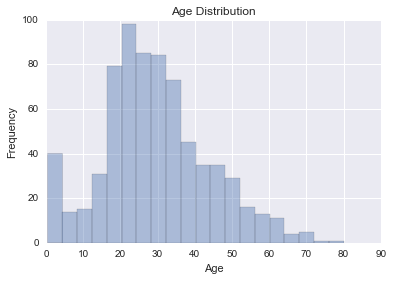

In [55]:
%pylab inline
import matplotlib.pyplot as plt
import seaborn as sns

sns.distplot(titanic_data['Age'][titanic_data['Age'].notnull()], kde = False).set(ylabel = 'Frequency', 
                                                                                  title = 'Age Distribution')

The distribution of ages appears to be somewhat normal, although there is a non normal peak at very young ages and a longer tail on the right hand side relative to the left hand side. This distribution suggests to me that I might need to consider age data from a different angle, by grouping passengers into intuitive age bands (e.g. a 'baby' category could capture the non normal left hand peak and an 'elderly' category could encompass the long right hand tail).

I have found these summary descriptions and distributions very useful for building intuition about the data. I am now ready to probe further, by looking at relationships between variables. I will begin by considering the relationship between gender and survival. 

In [56]:
# Break the gender data down by survival

titanic_data.groupby('Sex').sum()['Survived']

Sex
female    233
male      109
Name: Survived, dtype: int64

Based on this grouping, I observe that more females survived than males. Given that we know that 64% of the total passengers were male, this observation suggests there might be a relationship between gender and survival, with females having a higher likelihood of surviving. I will now quantify the relative survival rate by gender.

In [57]:
# Compute relative survival rates, by gender

total_females = titanic_data.groupby('Sex').count()['PassengerId']['female']
survived_females = titanic_data.groupby('Sex').sum()['Survived']['female']
female_survival = survived_females * 100 / total_females

total_males = titanic_data.groupby('Sex').count()['PassengerId']['male']
survived_males = titanic_data.groupby('Sex').sum()['Survived']['male']
male_survival = survived_males * 100 / total_males

print "Survival by Gender:"
print "\n"
print "Total female passengers: " + str(total_females)
print "Surviving female passengers: " + str(survived_females)
print "Female Survival Rate (%): " + str(female_survival)

print "\n"
print "Total male passengers: " + str(total_males)
print "Surviving male passengers: " + str(survived_males)
print "Male Survival Rate (%): " + str(male_survival)

Survival by Gender:


Total female passengers: 314
Surviving female passengers: 233
Female Survival Rate (%): 74


Total male passengers: 577
Surviving male passengers: 109
Male Survival Rate (%): 18


Therefore, survival appears to be quite strongly related to gender, with 74% of the female passengers surviving whereas only 18% of the males survived.

At this point, I would like to calculate a correlation coefficient between gender and survival. In order to do so, I need to convert the gender data from a string to a number. I will create a function, called numerical_gender, that returns a 1 for a female and a 0 for a male.

In [58]:
# Function returns a 1 if the data point is female and a 0 otherwise

def numerical_gender(df):
    
    if df == 'female':
        new_df = 1
    else:
        new_df = 0
        
    return new_df

In [59]:
# Apply the function to the titanic_data and calculate a correlation coefficient between gender and survival

titanic_data['Gender'] = titanic_data['Sex'].apply(numerical_gender)

np.corrcoef(titanic_data['Survived'],titanic_data['Gender'])

array([[ 1.        ,  0.54335138],
       [ 0.54335138,  1.        ]])

Given a 0.54 correlation coefficient, there is a moderate, positive relationship between gender and survival, with females having a greater chance of survival than males (since a 'Gender' value of 1 is used for females).

Now lets consider the relationship between class and survival.

In [60]:
# Break the class data down by survival

titanic_data.groupby('Pclass').sum()['Survived']

Pclass
1    136
2     87
3    119
Name: Survived, dtype: int64

Based on this grouping, I observe that more more 1st class passengers survived than either 2nd or 3rd class passengers. Given that we know that the median cabin class was 3rd class (i.e. >50% of the passengers were in 3rd class), this observation suggests there might be an inverse relationship between class and survival, with 1st class conferring a greater chance of survival. Let us quantify the relative survival rate by cabin class.

To do so, I will convert the cabin class data into a string (it is currently the integers 1,2 and 3). I will do so by applying a function, called class_to_string:

In [61]:
# Function converts the cabin classes from 1,2, and 3 to 1st, 2nd and 3rd

def class_to_string(df):
    
    if df == 1:
        new_df = '1st'
    elif df == 2:
        new_df = '2nd'
    else:
        new_df = '3rd'
    return new_df

In [62]:
# Apply the function to the titanic_data, creating a 'Class' column:

titanic_data['Class'] = titanic_data['Pclass'].apply(class_to_string)

In [63]:
# Compute relative survival rates, by class

total_first = titanic_data.groupby('Class').count()['PassengerId']['1st']
survived_first = titanic_data.groupby('Class').sum()['Survived']['1st']
first_survival = survived_first * 100 / total_first

total_second = titanic_data.groupby('Class').count()['PassengerId']['2nd']
survived_second = titanic_data.groupby('Class').sum()['Survived']['2nd']
second_survival = survived_second * 100 / total_second

total_third = titanic_data.groupby('Class').count()['PassengerId']['3rd']
survived_third = titanic_data.groupby('Class').sum()['Survived']['3rd']
third_survival = survived_third * 100 / total_third


print "Survival by Class:"
print "\n"
print "Total 1st class passengers: " + str(total_first)
print "Surviving 1st class passengers: " + str(survived_first)
print "1st class Survival Rate (%): " + str(first_survival)

print "\n"
print "Total 2nd class passengers: " + str(total_second)
print "Surviving 2nd class passengers: " + str(survived_second)
print "2nd class Survival Rate (%): " + str(second_survival)

print "\n"
print "Total 3rd class passengers: " + str(total_third)
print "Surviving 3rd class passengers: " + str(survived_third)
print "3rd class Survival Rate (%): " + str(third_survival)

Survival by Class:


Total 1st class passengers: 216
Surviving 1st class passengers: 136
1st class Survival Rate (%): 62


Total 2nd class passengers: 184
Surviving 2nd class passengers: 87
2nd class Survival Rate (%): 47


Total 3rd class passengers: 491
Surviving 3rd class passengers: 119
3rd class Survival Rate (%): 24


Based on these results, there does appear to be an inverse correlation with class and survival, with the survival rate of a 1st class passenger (62%) nearly triple that of a 3rd class passenger (24%). The correlation coefficient between class and survival can be calculated to quantify this relationship:

In [64]:
np.corrcoef(titanic_data['Survived'],titanic_data['Pclass'])

array([[ 1.        , -0.33848104],
       [-0.33848104,  1.        ]])

Given a -0.34 correlation coefficient, there is a moderate, negative relationship between class and survival, with upper class (1st class passengers) having a greater chance of survival than middle and lower class passengers.

As the 3rd variable pair considered, I would like to look at the relationship between age and survival. As with prior analyses, I will begin by looking at a grouping:

In [65]:
titanic_data.groupby('Age').sum()['Survived']

Age
0.42      1
0.67      1
0.75      2
0.83      2
0.92      1
1.00      5
2.00      3
3.00      5
4.00      7
5.00      4
6.00      2
7.00      1
8.00      2
9.00      2
10.00     0
11.00     1
12.00     1
13.00     2
14.00     3
14.50     0
15.00     4
16.00     6
17.00     6
18.00     9
19.00     9
20.00     3
20.50     0
21.00     5
22.00    11
23.00     5
         ..
44.00     3
45.00     5
45.50     0
46.00     0
47.00     1
48.00     6
49.00     4
50.00     5
51.00     2
52.00     3
53.00     1
54.00     3
55.00     1
55.50     0
56.00     2
57.00     0
58.00     3
59.00     0
60.00     2
61.00     0
62.00     2
63.00     2
64.00     0
65.00     0
66.00     0
70.00     0
70.50     0
71.00     0
74.00     0
80.00     1
Name: Survived, dtype: int64

There are too many age bands to draw any meaningful conclusions from the grouping. I will therefore group the data into the following (somewhat arbitrary) classifications, by applying the 'age_to_band' function specified hereafter:

    Age 0 to 2:   Baby

    Age 2 to 12:  Child

    Age 12 to 18: Teen

    Age 18 to 30: Young_Adult

    Age 30 to 55: Middle_Aged

    Age >55:      Elderly
    
As you may recall from the 'data wrangling' stage, I identified that age data was only provided for 714 of the 891 passengers under consideration here. For those passengers were the age is unknown, I will group them into an 'Age_Unknown' bracket and exclude them from the age / survival analysis.

In [66]:
# Function classifies a passenger's numerical age into 1 of 7 mutually exclusive age bands

def age_to_band(df):
    
    if df <= 2:
        new_df = 'Baby'
    elif df <= 12:
        new_df = 'Child'
    elif df <= 18:
        new_df = 'Teen'
    elif df <= 30:
        new_df = 'Young_Adult'
    elif df <= 55:
        new_df = 'Middle_Aged'
    elif df <= 200:
        new_df = 'Elderly'
    else:
        new_df = 'Age_Unknown'
        
    return new_df

In [67]:
# Apply the function to the titanic_data, creating an 'Age_Band' column:

titanic_data['Age_Band'] = titanic_data['Age'].apply(age_to_band)

Now lets reconsider how the data groups, by age band:

In [68]:
titanic_data.groupby('Age_Band').sum()['Survived']

Age_Band
Age_Unknown     52
Baby            15
Child           25
Elderly         12
Middle_Aged    112
Teen            30
Young_Adult     96
Name: Survived, dtype: int64

In [69]:
# Compute relative survival rates, by age band

total_baby = titanic_data.groupby('Age_Band').count()['PassengerId']['Baby']
survived_baby = titanic_data.groupby('Age_Band').sum()['Survived']['Baby']
baby_survival = survived_baby * 100 / total_baby

total_child = titanic_data.groupby('Age_Band').count()['PassengerId']['Child']
survived_child = titanic_data.groupby('Age_Band').sum()['Survived']['Child']
child_survival = survived_child * 100 / total_child

total_teen = titanic_data.groupby('Age_Band').count()['PassengerId']['Teen']
survived_teen = titanic_data.groupby('Age_Band').sum()['Survived']['Teen']
teen_survival = survived_teen * 100 / total_teen

total_young_adult = titanic_data.groupby('Age_Band').count()['PassengerId']['Young_Adult']
survived_young_adult = titanic_data.groupby('Age_Band').sum()['Survived']['Young_Adult']
young_adult_survival = survived_young_adult * 100 / total_young_adult

total_middle_aged = titanic_data.groupby('Age_Band').count()['PassengerId']['Middle_Aged']
survived_middle_aged = titanic_data.groupby('Age_Band').sum()['Survived']['Middle_Aged']
middle_aged_survival = survived_middle_aged * 100 / total_middle_aged

total_elderly = titanic_data.groupby('Age_Band').count()['PassengerId']['Elderly']
survived_elderly = titanic_data.groupby('Age_Band').sum()['Survived']['Elderly']
elderly_survival = survived_elderly * 100 / total_elderly


print "Survival by Age:"
print "\n"
print "Total baby passengers: " + str(total_baby)
print "Surviving baby passengers: " + str(survived_baby)
print "Baby Survival Rate (%): " + str(baby_survival)

print "\n"
print "Total child passengers: " + str(total_child)
print "Surviving child passengers: " + str(survived_child)
print "Child Survival Rate (%): " + str(child_survival)

print "\n"
print "Total teen passengers: " + str(total_teen)
print "Surviving teen passengers: " + str(survived_teen)
print "Teen Survival Rate (%): " + str(teen_survival)

print "\n"
print "Total young adult passengers: " + str(total_young_adult)
print "Surviving young adult passengers: " + str(survived_young_adult)
print "Young adult Survival Rate (%): " + str(young_adult_survival)

print "\n"
print "Total middle aged passengers: " + str(total_middle_aged)
print "Surviving middle aged passengers: " + str(survived_middle_aged)
print "Middle aged Survival Rate (%): " + str(middle_aged_survival)

print "\n"
print "Total elderly passengers: " + str(total_elderly)
print "Surviving elderly passengers: " + str(survived_elderly)
print "Elderly Survival Rate (%): " + str(elderly_survival)

Survival by Age:


Total baby passengers: 24
Surviving baby passengers: 15
Baby Survival Rate (%): 62


Total child passengers: 45
Surviving child passengers: 25
Child Survival Rate (%): 55


Total teen passengers: 70
Surviving teen passengers: 30
Teen Survival Rate (%): 42


Total young adult passengers: 270
Surviving young adult passengers: 96
Young adult Survival Rate (%): 35


Total middle aged passengers: 265
Surviving middle aged passengers: 112
Middle aged Survival Rate (%): 42


Total elderly passengers: 40
Surviving elderly passengers: 12
Elderly Survival Rate (%): 30


I will summarize the key age / survival rate data in graphical form:

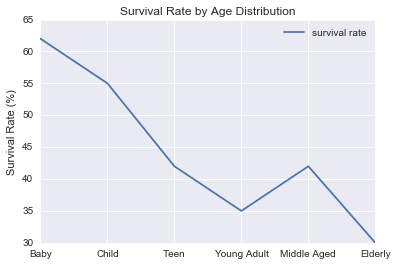

In [70]:
survival_by_age_df = pd.DataFrame(
    data={'survival rate': [baby_survival, child_survival, teen_survival, young_adult_survival, middle_aged_survival, 
                            elderly_survival]},
    index=['Baby', 'Child', 'Teen', 'Young Adult', 'Middle Aged', 'Elderly'])

survival_by_age_df.plot()
plt.ylabel('Survival Rate (%)')
plt.title('Survival Rate by Age Distribution')

There certainly appears to be a decreasing survival rate with age, with the rate going from 62% for babies to 29% for the elderly. 

To quantify this apparent inverse relationship, I will calculate the age / survival correlation coefficient. At the same time, I will generate correlation coefficients between all quantifiable variables in the data, to make sure no other particularly interesting relationships exist. This correlation data is presented in the table below:

In [71]:
titanic_data.corr()

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare,Gender
PassengerId,1.000000,-0.005007,-0.035144,0.036847,-0.057527,-0.001652,0.012658,-0.042939
Survived,-0.005007,1.000000,-0.338481,-0.077221,-0.035322,0.081629,0.257307,0.543351
Pclass,-0.035144,-0.338481,1.000000,-0.369226,0.083081,0.018443,-0.549500,-0.131900
Age,0.036847,-0.077221,-0.369226,1.000000,-0.308247,-0.189119,0.096067,-0.093254
SibSp,-0.057527,-0.035322,0.083081,-0.308247,1.000000,0.414838,0.159651,0.114631
Parch,-0.001652,0.081629,0.018443,-0.189119,0.414838,1.000000,0.216225,0.245489
Fare,0.012658,0.257307,-0.549500,0.096067,0.159651,0.216225,1.000000,0.182333
Gender,-0.042939,0.543351,-0.131900,-0.093254,0.114631,0.245489,0.182333,1.000000


Therefore, there is a negative correlation between age and survival, as the data and graph suggested. However, the correlation is weak (-0.08), suggesting that the effect of age on survival is not as strong as that of gender and class, which had correlations of 0.54 and -0.34 respectively.

Other than class and gender, the only other variable that appears to have a moderate correlation with survival is 'Fare'. However, given that fare is the price paid for the ticket, this is a proxy for class, so I will not explore it further. Thus, I believe I have considered the most interesting variable pair relationships.

As a final exercise, I would like to address the relationship between multiplie variables and survival. In particular, since both class and gender were moderatley predictive of survival, I would like to consider what sort of predictive power a combination of these two variables might provide. For example, how does the survival rates of first class females compare to third class males (very favorably, one can guess, based on the analysis so far)?

To address this question, I will begin by grouping across both gender and class:

In [72]:
titanic_data.groupby(['Sex','Class']).sum()['Survived']

Sex     Class
female  1st      91
        2nd      70
        3rd      72
male    1st      45
        2nd      17
        3rd      47
Name: Survived, dtype: int64

Next, consider the relative survival rates, by normalizing for the total number of respective passenger type:

In [73]:
# Compute relative survival rates, by gender and class

total_female_first = titanic_data.groupby(['Sex','Class']).count()['PassengerId']['female']['1st']
survived_female_first = titanic_data.groupby(['Sex','Class']).sum()['Survived']['female']['1st']
female_first_survival = survived_female_first * 100 / total_female_first

total_female_second = titanic_data.groupby(['Sex','Class']).count()['PassengerId']['female']['2nd']
survived_female_second = titanic_data.groupby(['Sex','Class']).sum()['Survived']['female']['2nd']
female_second_survival = survived_female_second * 100 / total_female_second

total_female_third = titanic_data.groupby(['Sex','Class']).count()['PassengerId']['female']['3rd']
survived_female_third = titanic_data.groupby(['Sex','Class']).sum()['Survived']['female']['3rd']
female_third_survival = survived_female_third * 100 / total_female_third

total_male_first = titanic_data.groupby(['Sex','Class']).count()['PassengerId']['male']['1st']
survived_male_first = titanic_data.groupby(['Sex','Class']).sum()['Survived']['male']['1st']
male_first_survival = survived_male_first * 100 / total_male_first

total_male_second = titanic_data.groupby(['Sex','Class']).count()['PassengerId']['male']['2nd']
survived_male_second = titanic_data.groupby(['Sex','Class']).sum()['Survived']['male']['2nd']
male_second_survival = survived_male_second * 100 / total_male_second

total_male_third = titanic_data.groupby(['Sex','Class']).count()['PassengerId']['male']['3rd']
survived_male_third = titanic_data.groupby(['Sex','Class']).sum()['Survived']['male']['3rd']
male_third_survival = survived_male_third * 100 / total_male_third

print "Survival by Gender and Class:"
print "\n"
print "Total 1st class females: " + str(total_female_first)
print "Surviving 1st class females: " + str(survived_female_first)
print "Female 1st class survival Rate (%): " + str(female_first_survival)

print "\n"
print "Total 2nd class females: " + str(total_female_second)
print "Surviving 2nd class females: " + str(survived_female_second)
print "Female 2nd class survival Rate (%): " + str(female_second_survival)

print "\n"
print "Total 3rd class females: " + str(total_female_third)
print "Surviving 3rd class females: " + str(survived_female_third)
print "Female 3rd class survival Rate (%): " + str(female_third_survival)

print "\n"
print "Total 1st class males: " + str(total_male_first)
print "Surviving 1st class males: " + str(survived_male_first)
print "Male 1st class survival Rate (%): " + str(male_first_survival)

print "\n"
print "Total 2nd class males: " + str(total_male_second)
print "Surviving 2nd class males: " + str(survived_male_second)
print "Male 2nd class survival Rate (%): " + str(male_second_survival)

print "\n"
print "Total 3rd class males: " + str(total_male_third)
print "Surviving 3rd class males: " + str(survived_male_third)
print "Male 3rd class survival Rate (%): " + str(male_third_survival)

Survival by Gender and Class:


Total 1st class females: 94
Surviving 1st class females: 91
Female 1st class survival Rate (%): 96


Total 2nd class females: 76
Surviving 2nd class females: 70
Female 2nd class survival Rate (%): 92


Total 3rd class females: 144
Surviving 3rd class females: 72
Female 3rd class survival Rate (%): 50


Total 1st class males: 122
Surviving 1st class males: 45
Male 1st class survival Rate (%): 36


Total 2nd class males: 108
Surviving 2nd class males: 17
Male 2nd class survival Rate (%): 15


Total 3rd class males: 347
Surviving 3rd class males: 47
Male 3rd class survival Rate (%): 13


Now summarize this data in bar chart form:

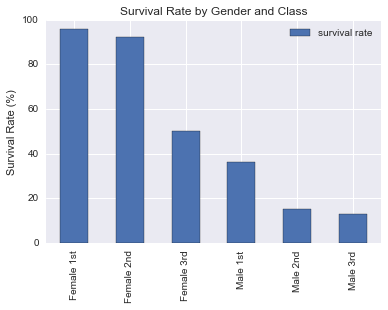

In [74]:
survival_by_gender_class_df = pd.DataFrame(
    data={'survival rate': [female_first_survival, female_second_survival, female_third_survival, male_first_survival, 
                            male_second_survival, male_third_survival]},
    index=['Female 1st', 'Female 2nd', 'Female 3rd', 'Male 1st', 'Male 2nd', 'Male 3rd'])

survival_by_gender_class_df.plot(kind='bar')
plt.ylabel('Survival Rate (%)')
plt.title('Survival Rate by Gender and Class')

The results shown in the graph are stark: Middle and upper class females had a strong chance of survival, with values approaching 100%, whereas middle and lower class males faced slim odds, with survival rates below 20%. 

Limitations:

While the analysis done here suggests there is a predictive relationship between survival and certain variables (gender and class, and possibly age), there are several limitations at play that warrant discussion and consideration. 

First, the data set is incomplete. The analysis covers only 891 of the 1,316 passengers on board (source: http://www.historyonthenet.com/titanic/passengers.htm). The survival rate is similar across the set considered here (342 out of 891 or 38.4%) versus the complete set (498 survived out of 1,316 or 37.8%), but without access to the complete set, we cannot be certain that there aren't biases in the subset chosen, in regards to age, gender, class or other variables.

Second, the dataset is not complete even for the passengers that were provided. For example, it was noted earlier that age data was not provided for 20% of the passengers (177 out of 891). A large amount of data is also missing for the 'Cabin' column, which was not a field considered here. With a complete list of cabin data, one might draw very different conclusions about why class played a critical role in determining survival (e.g. 1st class cabins might have all been clustered near lifeboats).

Third, this dataset only captures a small amount of what was certainly a very interesting and diverse passenger base. The individual habits and tastes of passengers would have likely played a role in survival. For example, certain passengers might have had a preference for staying up late playing cards, drinking and smoking cigars whereas others might have had a preference for an early night. Religious or employment data could begin to reveal some of these social or cultural complexities, which could have made the difference between life and death on that fateful night.

Fourth, this analysis has not attempted to do any rigorous statistical tests on the results to assess their significance. Although the means and correlation coefficients suggest there are meaningful relationships between the variables considered, it cannot be stated that the results are statistically signficant, since the appropriate tests were outside the scope of this project.

Conclusion:
    
In this analysis, I considered the question of whether the chance of surviving the Titanic shipwreck disaster was related to the age, gender or social class of the passengers. The results were quite fascinating. There was a moderate correlation (0.54) between gender and survival, implying that women had a higher chance of surviving the disaster, and another moderate correlation (-0.34) between class and survival, implying a higher social class also increased the chance of survival. There also appears to be a slight correlation (-0.08) between age and survival, with youth enhancing the chance of survival. This effect looked more pronounced when the ages were split into various groups, with babies (as defined as those in the age range 0-2 years) surviving at a 62% rate compared to the elderly (those over 55 years) surviving at only a 29% rate. So it looks like the saying, "women and children first!", held strong during the Titanic disaster.

The most pronounced results came when considering the combined effect of gender and class on survival rate. Here I found that upper and middle class females survived at rates of 96% and 92% respectively, a remarkable contrast to the 15% and 13% survival rate for middle and lower class males respectively.

This data was truly illuminating to me, as the numbers demonstrated a powerful human story: They illustrated both the valiant side of human nature (men forgoing their own survival to aid women and children) and the darker side (social class being a major determinant of survival).